# Процессы Хокса (Hawkes Processes)

Процесс Хокса полностью определяется своей функцией интенсивности, которая в общем виде выглядит так:

$$ λ(t|ℋ_t) = λ_0(t) + \sum_{i:t>T_i} φ(t - T_i) $$

где

- $ ℋ_t $ - полная история событий, вплоть до момента $ t $
- $ λ_0(t) $ - базовая интенсивность событий; в простейшем случае $ λ_0(t) = λ_0 = const $ (случай Пуассоновского процесса)
- $ φ(x) $ - ядро "памяти"; чаще всего принимается за монотонно убывающую функцию (интерпретация: события из недавнего прошлого оказывают бОльшее влияние на текущую интенсивность, чем события из далекого прошлого)

# 0. Начало

In [79]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from scipy import optimize, integrate
from IPython.display import display, clear_output

np.random.seed(42)

# 1. Сэмплинг (один пользователь)

In [65]:
class HawkesSampler:
    N = None
    time_period = None
    alpha = None
    beta = None
    lambda_base_const = None
    lambda_base_func = lambda: None

    def __init__(self, N, alpha, beta, time_period=None, l0_const=None, l0_func=None):
        self.N = N
        self.time_period = time_period
        self.alpha = alpha
        self.beta = beta
        self.events = []
        self.iterations = 0

        if l0_func != None:
            self.lambda_base_func = l0_func
            self.is_base_func = True
        else:
            self.lambda_base_const = l0_const if l0_const != None else 0
            self.is_base_func = False

    # экспоненциальное ядро памяти
    def memory_kernel(self, x):
        return self.alpha * math.exp(-self.beta * x)

    # λ(t), функция интенсивности
    def intensity(self, t):
        s = self.lambda_base_func(t) if self.is_base_func else self.lambda_base_const
        for e in self.events:
            if e >= t: break
            s += self.memory_kernel(t - e)
        return s

    # Прореживающий [др: отвергающий] алгоритм
    # Thinning [other: rejection] algorithm
    # Сложность - O(n^2)
    def sample(self):
        self.events.clear()
        T, i = 0.0, 1

        while i <= self.N:
            self.iterations += 1
            upper_bound = self.intensity(T) # λ*
            u = random.random() # 0...1
            tau = -(math.log(u) / upper_bound) # 𝜏
            T += tau

            if self.time_period != None and T > self.time_period:
                break

            s = random.random()
            edge = self.intensity(T) / upper_bound
            if s <= edge:
                self.events.append(T)
                i += 1

        return self.events

In [115]:
alpha_real = 0.7
beta_real = 1.5
mu_real = 0.25
T = 30 * 12

In [116]:
sampler = HawkesSampler(N = T, time_period=T, alpha=alpha_real, beta=beta_real, l0_const=mu_real)
events = sampler.sample()
max_time = events[-1]

print(f"{len(events)} событий сгенерировано за {sampler.iterations} тактов. Метка времени последнего события: {max_time}")

123 событий сгенерировано за 147 тактов. Метка времени последнего события: 359.5267422304535


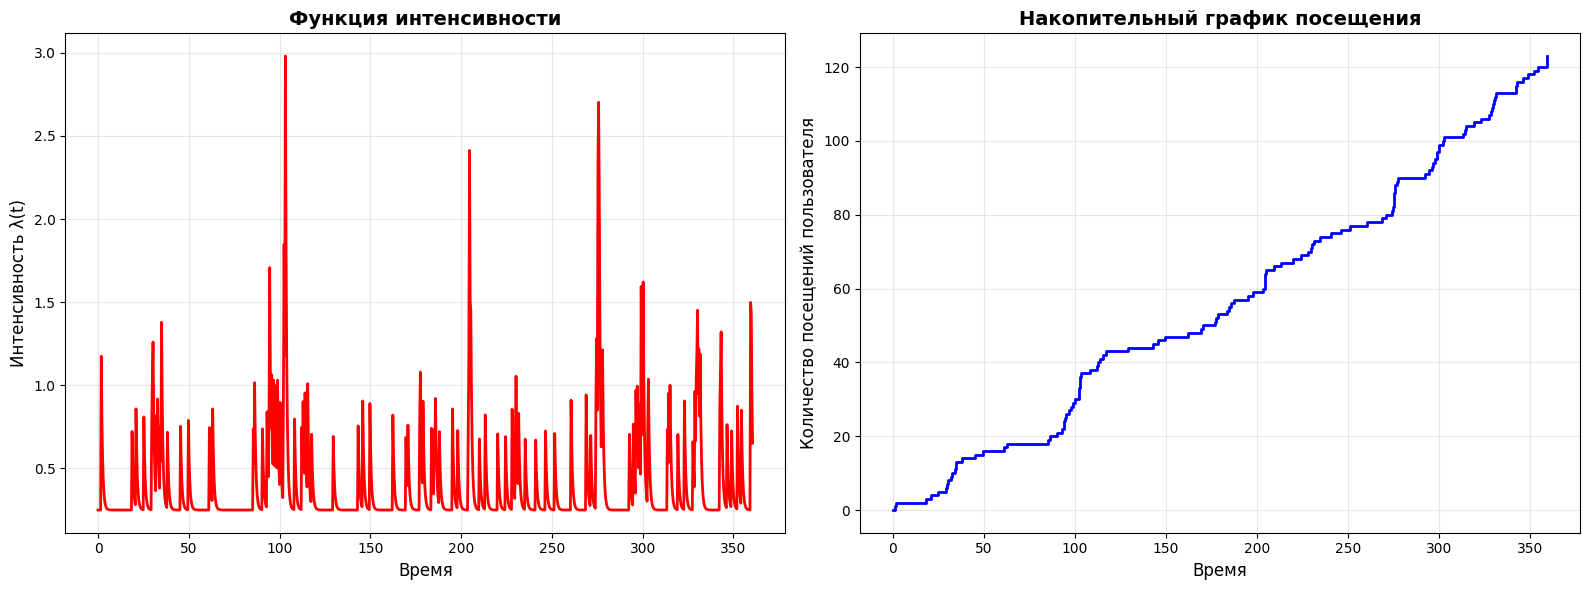

In [117]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

time_range = np.linspace(0, max(events) + 1, 1000)
intensities = [sampler.intensity(t) for t in time_range]

ax1.plot(time_range, intensities, linewidth=2, color='red')
ax1.set_xlabel('Время', fontsize=12)
ax1.set_ylabel('Интенсивность λ(t)', fontsize=12)
ax1.set_title('Функция интенсивности', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)

graph_events = [0.0] + events
graph_counts = [0] + list(range(1, len(events) + 1))

ax2.step(graph_events, graph_counts, where='post', linewidth=2, color='blue')
ax2.set_xlabel('Время', fontsize=12)
ax2.set_ylabel('Количество посещений пользователя', fontsize=12)
ax2.set_title('Накопительный график посещения', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 2. Моделирование гиперпараметров

...или процесс parameter fitting/estimation. В нашем случае мы хотим оценить функцию базовой интенсивности $ λ_0(t) $ и параметры ядра экспоненциального памяти: $ α $ (влияние одного события на последующие) и $ β $ (длина памяти) 

*Здесь будет обоснование оценки параметров*

In [118]:
class HawkesFitter:
    events = None
    T = None
    initial_params = None

    def __init__(self, events, T, init_params):
        self.events = events
        self.T = T
        self.initial_params = init_params

    # экспоненциальное ядро памяти
    def memory_kernel(self, x, alpha, beta):
        return alpha * math.exp(-beta * x)

    # λ(t), функция интенсивности
    def intensity(self, t, alpha, beta, mu):
        s = mu
        for e in self.events:
            if e >= t:
                break
            s += self.memory_kernel(t - e, alpha, beta)
        return s

    def neg_log_like(self, params):
        alpha, beta, mu = params
        integral = mu * self.T
        for e in self.events:
            if e < self.T:
                integral += (alpha / beta) * (1 - math.exp(-beta * (self.T - e)))

        log_part = 0.0
        for e in self.events:
            log_part += math.log(self.intensity(e, alpha, beta, mu))

        return integral - log_part

    def fit(self):
        return optimize.minimize(
            self.neg_log_like, 
            self.initial_params, 
            method='L-BFGS-B', 
            bounds=[(1e-5, None), (1e-5, None), (1e-5, None)]
        )

In [119]:
fitter = HawkesFitter(events, T=T, init_params=[0.5, 1.0, 0.1])
res = fitter.fit()

print("Success:", res.success)

alpha_estim, beta_estim, mu_estim = res.x
print(f"alpha. Estim: {alpha_estim:.4f}, real: {alpha_real:.4f}")
print(f"beta. Estim: {beta_estim:.4f}, real: {beta_real:.4f}")
print(f"mu. Estim: {mu_estim:.4f}, real: {mu_real:.4f}")

Success: True
alpha. Estim: 0.3061, real: 0.7000
beta. Estim: 0.8511, real: 1.5000
mu. Estim: 0.2206, real: 0.2500


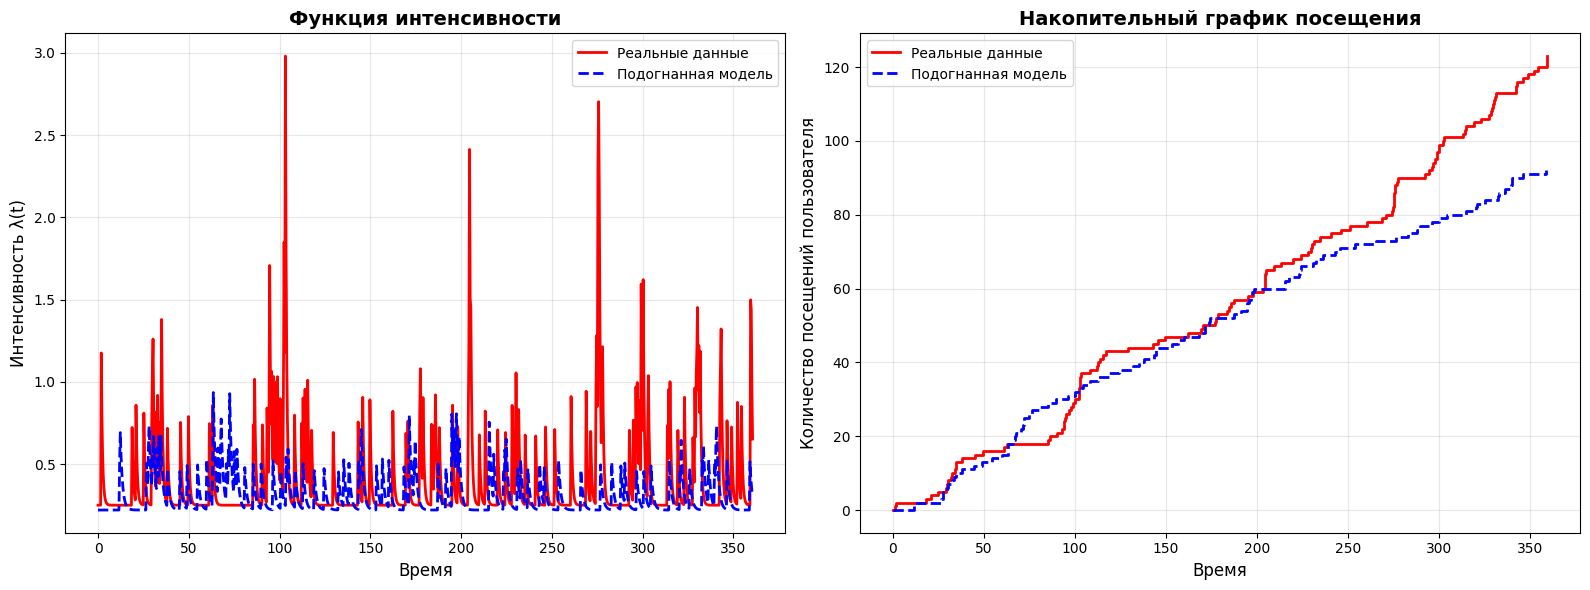

In [120]:
estim_sampler = HawkesSampler(N = T, time_period=T, alpha=alpha_estim, beta=beta_estim, l0_const=mu_estim)
estim_events = estim_sampler.sample()
max_time = events[-1]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

time_range = np.linspace(0, max_time + 1, 1000)
estim_intensities = [estim_sampler.intensity(t) for t in time_range]
real_intensities = [sampler.intensity(t) for t in time_range]

ax1.plot(time_range, real_intensities, linewidth=2, color="red", label="Реальные данные")
ax1.plot(time_range, estim_intensities, linewidth=2, color="blue", linestyle="--", label="Подогнанная модель")
ax1.set_xlabel("Время", fontsize=12)
ax1.set_ylabel("Интенсивность λ(t)", fontsize=12)
ax1.set_title("Функция интенсивности", fontsize=14, fontweight="bold")
ax1.legend()
ax1.grid(True, alpha=0.3)

real_graph_events = [0.0] + events
real_graph_counts = [0] + list(range(1, len(events) + 1))
estim_graph_events = [0.0] + estim_events
estim_graph_counts = [0] + list(range(1, len(estim_events) + 1))

ax2.step(real_graph_events, real_graph_counts, where="post", linewidth=2, color="red", label="Реальные данные")
ax2.step(estim_graph_events, estim_graph_counts, where="post", linewidth=2, color="blue", linestyle="--", label="Подогнанная модель")
ax2.set_xlabel("Время", fontsize=12)
ax2.set_ylabel("Количество посещений пользователя", fontsize=12)
ax2.set_title("Накопительный график посещения", fontsize=14, fontweight="bold")
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()